<a href="https://colab.research.google.com/github/NicoMontoya/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/module3-model-interpretation/assignment_feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1616k    0 1616k    0     0   832k      0 --:--:--  0:00:01 --:--:--  832k


In [134]:
!wget https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv

--2019-05-15 20:49:28--  https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 234945 (229K) [text/plain]
Saving to: ‘BicycleWeather.csv.4’

BicycleWeather.csv. 100%[===================>] 229.44K  --.-KB/s    in 0.05s   

2019-05-15 20:49:28 (4.55 MB/s) - ‘BicycleWeather.csv.4’ saved [234945/234945]



In [0]:
import pandas as pd
import numpy as np

def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily

daily = load()

In [136]:
daily.head(2)


,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
2012-10-04,3475.0,0,0,0,189,83,65,3521.0
2012-10-05,3148.0,0,0,0,217,89,57,3475.0


In [137]:
train = daily[:-100] # first, up to last 100 days -train
test = daily[-100:] # last one hundred days - test

train.shape, test.shape

((963, 8), (100, 8))

In [138]:
X_train = train.drop(columns='Total')
y_train = train['Total']

X_test = test.drop(columns='Total')
y_test = test['Total']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((963, 7), (963,), (100, 7), (100,))

In [0]:
def jake_wrangle_nico_add(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))

    
    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10
    
    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])

    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.
    
    # Nico extra features
    
    #replace -9999 with 0's
    X = X.replace(-9999, 0)
    
    # day before, more than the average amount of bikers 
    X['more_than_average_day_before'] = (X['Total_yesterday'] > X['Total_yesterday'].mean()).astype(int)
    
    # it's da weekend
    X['weekend'] = ((X['Sat'] == 1.0)| (X['Sun'] == 1.0)).astype(int)
    
    # it is cold AND rainy
    X['cold_and_rainy'] = ((X['Temp (C)'] < 10) & (X['PRCP'] > 0)).astype(int)


    return X

In [0]:
X_train = jake_wrangle_nico_add(X_train)

In [141]:
X_train.head(2)

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Temp (C),dry day,annual,more_than_average_day_before,weekend,cold_and_rainy
2012-10-04,0.0,0,0,18.9,8.3,65,3521.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,13.6,1,0.00000,1,0,0
2012-10-05,0.0,0,0,21.7,8.9,57,3475.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,15.3,1,0.00274,1,0,0


In [142]:
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(2,4)
}

search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions=param_distributions,
    n_iter=2,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=3,
    verbose=10,
    return_train_score=True,
    random_state=42
)

search.fit(X_train.values, y_train.values)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1817s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.4s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4563289ba8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4563289cf8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [143]:
print('Cross-Validation best Mean absolute error:', -search.best_score_)

Cross-Validation best Mean absolute error: 276.76581609929957


In [144]:
from sklearn.metrics import mean_absolute_error

best = search.best_estimator_
X_test = jake_wrangle_nico_add(X_test)
y_pred = best.predict(X_test.values)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

Test Mean Absolute Error: 237.9613671875


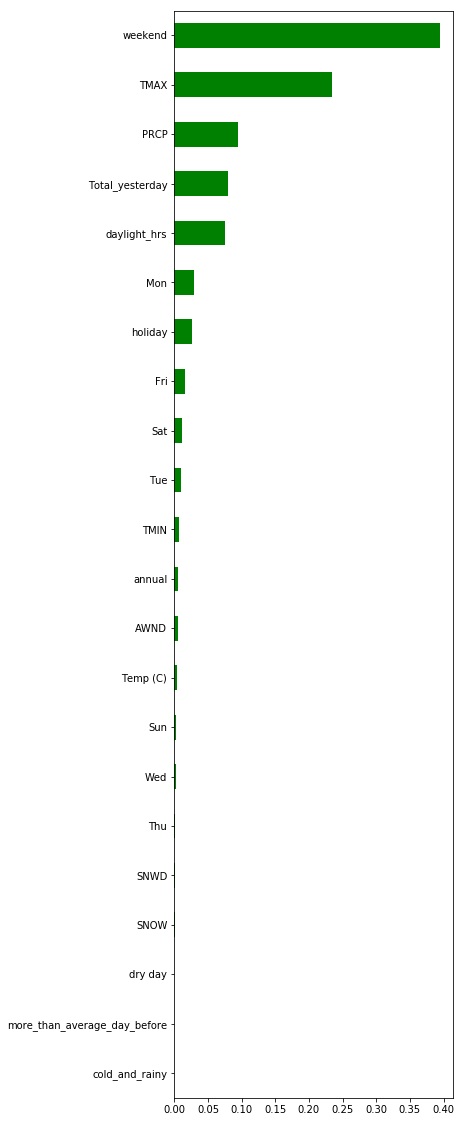

In [145]:
n = 100

figsize = (5, 20)

importances = pd.Series(best.feature_importances_, X_train.columns)
top_n = importances.sort_values()[-n:]

plt.figure(figsize=figsize)

top_n.plot.barh(color='green')

In [146]:
!pip install eli5

In [147]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, scoring='neg_mean_absolute_error', cv='prefit',
                                 n_iter=2, random_state=42)

permuter.fit(X_test.values, y_test)

PermutationImportance(cv='prefit',
           estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=229, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
           n_iter=2, random_state=42, refit=True,
           scoring='neg_mean_absolute_error')

In [148]:
feature_names = X_test.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
618.8665 ± 132.3287,weekend
118.7079 ± 2.1021,Total_yesterday
65.7003 ± 25.1288,PRCP
65.2492 ± 5.1435,TMAX
46.7083 ± 19.6068,Fri
33.7306 ± 3.1055,holiday
29.1534 ± 8.3601,Tue
19.8318 ± 0.7038,Sat
17.5610 ± 17.3455,TMIN
9.2734 ± 0.8907,Mon


In [149]:
print('shape before removing features: ', X_train.shape)

shape before removing features:  (963, 22)


In [171]:
print('Shape before removing features', X_train.shape)

mask = permuter.feature_importances_ > 0

features = X_train.columns[mask]
X_train_permuted = X_train[features]
X_test_permuted = X_test[features]

print('Shape after removing features: ', X_train_permuted.shape)

Shape before removing features (963, 22)
Shape after removing features:  (963, 13)


In [172]:
X_train.shape

(963, 22)

In [178]:
param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(2,4)
}

search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions=param_distributions,
    n_iter=2,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=3,
    verbose=10,
    return_train_score=True,
    random_state=42
)

search.fit(X_train_permuted, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1583s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f45631cc4a8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f45631cc128>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [179]:
print('Cross-Validation best Mean absolute error:', -search.best_score_)

Cross-Validation best Mean absolute error: 273.94367921736136


In [181]:
best = search.best_estimator_
y_pred = best.predict(X_test_permuted)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

Test Mean Absolute Error: 246.94039672851562


In [0]:
!pip install pdpbox

In [176]:
X_test.head()

,PRCP,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Fri,Sat,holiday,daylight_hrs,weekend
2015-05-25,0.0,15.6,11.1,27,1776.0,1.0,0.0,0.0,0.0,0.0,1.0,15.269661,0
2015-05-26,0.0,21.7,11.7,21,1737.0,0.0,1.0,0.0,0.0,0.0,0.0,15.303607,0
2015-05-27,0.0,24.4,11.7,18,4254.0,0.0,0.0,1.0,0.0,0.0,0.0,15.336561,0
2015-05-28,0.0,27.8,12.2,21,4771.0,0.0,0.0,0.0,0.0,0.0,0.0,15.368497,0
2015-05-29,0.0,26.1,12.8,25,5142.0,0.0,0.0,0.0,1.0,0.0,0.0,15.399396,0


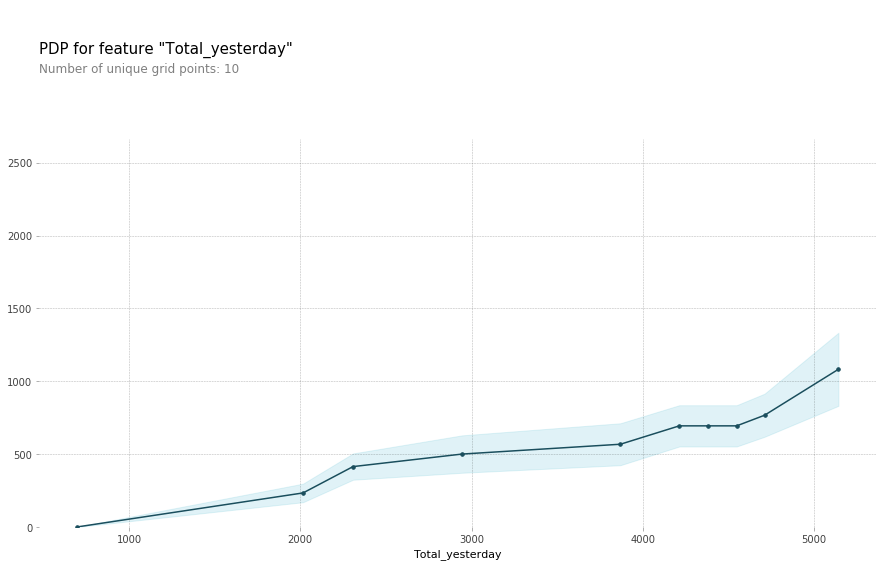

In [182]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Total_yesterday'

isolated = pdp_isolate(
    model = best,
    dataset = X_test_permuted,
    model_features = X_test_permuted.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f45630ad710>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f45630e8ba8>})

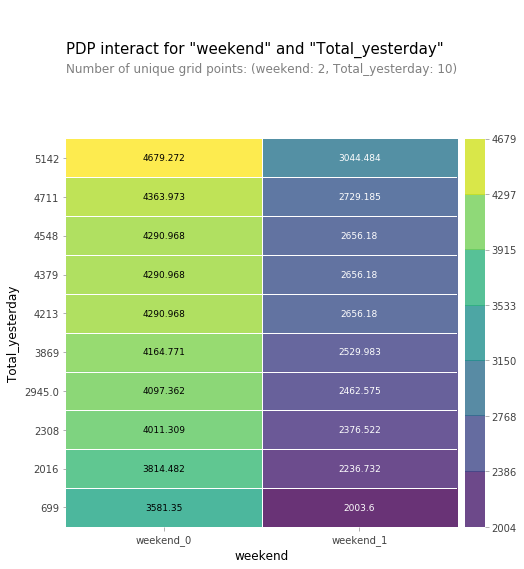

In [184]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['weekend', 'Total_yesterday']

interaction = pdp_interact(
    model=best,
    dataset=X_test_permuted,
    model_features=X_test_permuted.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

In [192]:
X_test_permuted.sample()

,PRCP,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Fri,Sat,holiday,daylight_hrs,weekend
2015-08-24,0.0,23.9,12.2,23,2016.0,1.0,0.0,0.0,0.0,0.0,0.0,13.641653,0


In [193]:
data_for_prediction = X_test_permuted[X_test_permuted.index=='2015-08-24']
data_for_prediction

,PRCP,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Fri,Sat,holiday,daylight_hrs,weekend
2015-08-24,0.0,23.9,12.2,23,2016.0,1.0,0.0,0.0,0.0,0.0,0.0,13.641653,0


In [194]:
!pip install shap

In [195]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)